<a href="https://colab.research.google.com/github/fateme-karami/online-retail-predict/blob/main/marketing_improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, delimiter='\t')

    # Selecting relevant features for customer behavior analysis
    features = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

    # Convert features to numeric and drop rows with NaN values
    data[features] = data[features].apply(pd.to_numeric, errors='coerce')
    data = data.dropna(subset=features)

    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[features])

    return data_scaled, features

###load_and_preprocess_data Function
The function starts by loading customer data from a file. This data includes details like customer income, time since the last purchase, and spending on various product categories, such as wines, fruits, meat, fish, sweets, and gold products. **These features are chosen as they provide insights into different aspects of customer behavior**.

Next, the function prepares the data for analysis. First, it ensures that all values in the selected features are in numeric format, converting any non-numeric values (like text or symbols) to a placeholder for missing data. Any rows that contain missing values in these features are then removed to keep the dataset complete and clean.

To make the data suitable for machine learning, it then standardizes these features. Standardization adjusts the values so that each feature has a similar scale, with a mean of 0 and a standard deviation of 1. This is crucial for clustering and other analyses that are sensitive to differences in scale across features.

Finally, the function returns this standardized data, which is now ready for further analysis, such as finding patterns in customer behavior. This careful preparation of the data ensures that it is both clean and scaled appropriately, making it ideal for reliable analysis results.

In [23]:
# Determine optimal number of PCA components and extract loadings
def optimal_pca_components(data_scaled, features):
    pca = PCA()
    pca.fit(data_scaled)
    explained_variance = pca.explained_variance_ratio_

    # Plot cumulative explained variance
    plt.figure(figsize=(6, 2))
    plt.plot(np.cumsum(explained_variance))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Number of Components')
    plt.grid(True)
    plt.show()

    # Choose optimal components based on explained variance > 80%
    optimal_components = np.argmax(np.cumsum(explained_variance) >= 0.8) + 1

    # Fit PCA with the optimal number of components
    pca = PCA(n_components=optimal_components)
    data_pca = pca.fit_transform(data_scaled)

    # Extract loadings for each component
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'Component {i+1}' for i in range(optimal_components)],
        index=features
    )
    print("PCA Loadings (Feature contributions to each component):")
    print(loadings)

    return data_pca, optimal_components

This section of code is designed to identify the optimal number of Principal Component Analysis (PCA) components needed to capture the majority of variance in the dataset. Here’s a breakdown of what each step achieves:

1. **Setting Up PCA**:
   The function starts by initializing a PCA model without specifying the number of components. This lets it calculate the variance explained by each potential component across the entire dataset.

2. **Calculating Explained Variance**:
   After fitting the PCA model to the standardized data, the function retrieves the explained variance ratio for each component. The explained variance ratio tells us how much information (or variance) each principal component contributes to the dataset as a whole.

3. **Plotting the Cumulative Explained Variance**:
   To visually understand how many components are needed, the function creates a cumulative plot of the explained variance. It plots the cumulative sum of explained variance against the number of components, showing how much total variance would be covered as more components are included. The x-axis represents the number of components, while the y-axis shows the cumulative explained variance.

4. **Selecting the Optimal Number of Components**:
   The function chooses the smallest number of components needed to capture at least 80% of the total variance in the dataset. This threshold (80%) is often used in data analysis to balance dimensionality reduction with information retention. The function finds this threshold by identifying where the cumulative explained variance reaches or exceeds 0.8 (or 80%).

5. **Transforming the Data with Optimal Components**:
   With the optimal number of components identified, the function performs PCA again using this number, transforming the original data into a lower-dimensional space. This transformation reduces the data’s complexity while retaining the essential variance for further analysis.

6. **Returning the Results**:
   Finally, the function returns both the transformed data and the optimal number of components, making the data ready for use in clustering or other analyses.

This approach to choosing PCA components helps simplify the data by retaining only the most informative components, enhancing the efficiency and interpretability of subsequent analysis.

### PCA Loadings: Interpreting Feature Contributions

The `loadings` DataFrame shows how much each original feature contributes to each principal component in the PCA transformation.

- **Purpose**: Loadings represent the **weight** of each feature for each principal component, helping us interpret what each component represents.
  
- **Columns**: Each column corresponds to a principal component (e.g., `Component 1`, `Component 2`, etc.), and each row corresponds to a feature (e.g., `Income`, `Recency`, etc.).

- **Interpretation**:
  - **Positive/Negative Values**: Positive values indicate a positive relationship with the component, and negative values indicate an inverse relationship.
  - **Magnitude**: Larger absolute values indicate that the feature has a stronger influence on the component. Features with higher loadings are more critical for defining the characteristics of that component.

This table enables us to understand and label components based on feature contributions, enhancing the interpretation of PCA in customer behavior analysis.

In [24]:
# Evaluate the optimal number of clusters
# This function tests cluster counts from 2 to 10 and evaluates each configuration using two metrics:
# - Silhouette Score: Measures how similar points are within clusters vs. across clusters. Higher values are better.
# - Davies-Bouldin Score: Measures the average ratio of within-cluster distances to between-cluster distances. Lower values are better.

def evaluate_clusters(data_pca):
    silhouette_scores = []  # Stores Silhouette scores for each cluster count
    db_scores = []  # Stores Davies-Bouldin scores for each cluster count
    k_range = range(2, 11)  # Testing clusters from 2 to 10

    # For each possible number of clusters (k), fit KMeans and evaluate
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data_pca)  # Assign clusters
        silhouette_scores.append(silhouette_score(data_pca, cluster_labels))  # Calculate Silhouette Score
        db_scores.append(davies_bouldin_score(data_pca, cluster_labels))  # Calculate Davies-Bouldin Score


    # Plot silhouette and Davies-Bouldin scores
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for each K')

    plt.subplot(1, 2, 2)
    plt.plot(k_range, db_scores, 'rx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Score for each K')
    plt.tight_layout()
    plt.show()

    # Recommend optimal number of clusters based on highest Silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
    return optimal_k

This section of code is designed to help determine the optimal number of clusters for a dataset by evaluating different clustering configurations using two key metrics: the **Silhouette Score** and the **Davies-Bouldin Score**. Here's a step-by-step explanation of the process:

1. **Evaluation of Different Cluster Counts**:
   - The function tests different cluster counts, ranging from 2 to 10, and evaluates how well each configuration performs based on the two metrics.

2. **Clustering the Data**:
   - For each cluster count (e.g., 2 clusters, 3 clusters, etc.), a clustering algorithm (KMeans) is used to group the data into the specified number of clusters.

3. **Silhouette Score**:
   - The Silhouette Score measures how similar data points are within the same cluster compared to points in other clusters. A higher score means that data points are well-clustered (close to others in the same cluster and far from points in other clusters).
   - The function calculates the Silhouette Score for each cluster count (2 to 10) and stores the results.

4. **Davies-Bouldin Score**:
   - The Davies-Bouldin Score evaluates how well-separated the clusters are. It measures the average ratio of the distances within clusters to the distances between clusters. A lower score indicates that the clusters are well-separated and distinct.
   - This score is also calculated for each cluster count and stored.

5. **Visualization**:
   - The function creates two plots:
     - One showing how the **Silhouette Score** changes with different numbers of clusters (ideally, higher scores indicate better clustering).
     - Another showing how the **Davies-Bouldin Score** changes (lower scores indicate better clustering).
   - These plots help visualize how each metric behaves with varying cluster counts.

6. **Choosing the Optimal Cluster Count**:
   - The function selects the number of clusters that gives the highest **Silhouette Score** because this indicates the best separation and cohesion within the clusters. This number is considered the optimal number of clusters.
   
In summary, the function helps to identify the best number of clusters by comparing different configurations using these two evaluation metrics. It picks the configuration that maximizes the Silhouette Score, as that is usually the best indicator of well-separated clusters.

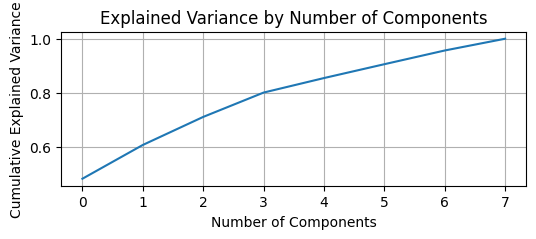

PCA Loadings (Feature contributions to each component):
                  Component 1  Component 2  Component 3  Component 4
Income               0.374739    -0.025217     0.488962    -0.150616
Recency              0.009363     0.998124    -0.010847    -0.029502
MntWines             0.363443     0.014388     0.576071     0.132777
MntFruits            0.389625    -0.036381    -0.371646    -0.135651
MntMeatProducts      0.416320     0.010930     0.166438    -0.220213
MntFishProducts      0.398882    -0.023617    -0.358017    -0.075139
MntSweetProducts     0.384966     0.015564    -0.338778    -0.251015
MntGoldProds         0.308150     0.025727    -0.142025     0.907340
Optimal PCA components: 4


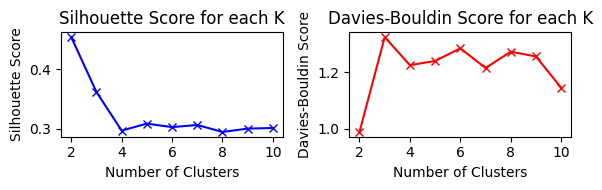

Optimal number of clusters based on Silhouette Score: 2


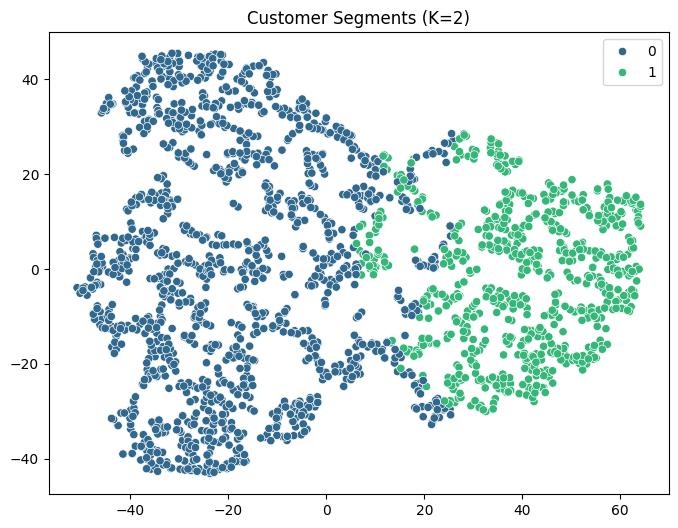

In [25]:
# Visualize clusters in 2D with t-SNE
def visualize_clusters(data_pca, optimal_k):
    # Fit KMeans with optimal clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(data_pca)

    # Reduce dimensions with t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data_pca)

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=clusters, palette="viridis")
    plt.title(f'Customer Segments (K={optimal_k})')
    plt.show()

# Main function to run the full pipeline
def main(file_path):
    # Step 1: Load and preprocess data
    data_scaled, features = load_and_preprocess_data(file_path)

    # Step 2: Perform PCA and get optimal components with loadings
    data_pca, optimal_components = optimal_pca_components(data_scaled, features)
    print(f"Optimal PCA components: {optimal_components}")

    # Step 3: Determine optimal number of clusters
    optimal_k = evaluate_clusters(data_pca)

    # Step 4: Visualize the clusters in 2D
    visualize_clusters(data_pca, optimal_k)

# Run the complete pipeline
file_path = '/content/sample_data/marketing_campaign (1).csv'
main(file_path)

### `visualize_clusters` function:
This function visualizes the clusters in 2D using **t-SNE** (t-distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the data. Here's how it works:

1. **Fitting KMeans with Optimal Clusters:**
   - `kmeans = KMeans(n_clusters=optimal_k, random_state=42)`: This creates an instance of the **KMeans** clustering algorithm with the optimal number of clusters, `optimal_k`, which is determined from the earlier cluster evaluation step (where the optimal value of `k` was chosen based on the **Silhouette Score**).
   - `clusters = kmeans.fit_predict(data_pca)`: This fits the **KMeans** model to the **PCA-transformed data** (`data_pca`) and assigns each data point to a cluster. The result, `clusters`, is a list of cluster labels (an integer assigned to each data point indicating which cluster it belongs to).

2. **Reducing Dimensions for Visualization with t-SNE:**
   - `tsne = TSNE(n_components=2, random_state=42)`: Here, **t-SNE** is instantiated with 2 components (2D), meaning the algorithm will reduce the high-dimensional **PCA data** (`data_pca`) to just 2 dimensions that can be easily visualized in a 2D plot.
   - `data_2d = tsne.fit_transform(data_pca)`: This applies the **t-SNE** algorithm to the **PCA-reduced data** (`data_pca`) to get a 2D representation (`data_2d`). Essentially, it takes the high-dimensional data and "compresses" it into two dimensions, preserving the relationships between data points, so that they can be visualized on a 2D plot.

3. **Plotting the Clusters:**
   - `plt.figure(figsize=(8, 6))`: This creates a figure for plotting with specified dimensions (8 inches by 6 inches).
   - `sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=clusters, palette="viridis")`: This uses **Seaborn** (`sns`) to create a scatter plot of the 2D data (`data_2d`). The `x` and `y` axes correspond to the two t-SNE components, while `hue=clusters` color-codes each data point based on its assigned cluster. The `palette="viridis"` specifies the color palette used to differentiate clusters visually.
   - `plt.title(f'Customer Segments (K={optimal_k})')`: This sets the title of the plot, indicating the number of clusters (K) used.
   - `plt.show()`: Finally, this command displays the plot.

### Main function (`main`):
The **main** function runs the complete pipeline, which includes loading, processing, and analyzing the data step-by-step.

1. **Step 1 - Load and preprocess data**:
   - `data_scaled, features = load_and_preprocess_data(file_path)`: This loads the data from the file, preprocesses it (selects features, converts them to numeric values, and scales them), and returns the scaled data (`data_scaled`) and the list of features used for analysis.

2. **Step 2 - Perform PCA**:
   - `data_pca, optimal_components = optimal_pca_components(data_scaled, features)`: This step runs **Principal Component Analysis (PCA)** on the scaled data to reduce the number of dimensions. It returns the PCA-transformed data (`data_pca`) and the optimal number of components used in the transformation.

3. **Step 3 - Determine optimal number of clusters**:
   - `optimal_k = evaluate_clusters(data_pca)`: This function evaluates the optimal number of clusters by testing different values of `k` (number of clusters) and selecting the value that maximizes the **Silhouette Score** (a measure of how well-separated the clusters are).

4. **Step 4 - Visualize the clusters**:
   - `visualize_clusters(data_pca, optimal_k)`: Finally, after finding the optimal number of clusters (`optimal_k`), the function `visualize_clusters` is called to display the clusters in a 2D scatter plot using **t-SNE**.

### Running the complete pipeline:
- `file_path = '/content/sample_data/marketing_campaign (1).csv'`: The file path of the dataset to be used.
- `main(file_path)`: This runs the entire process by calling the `main` function, which orchestrates the steps of loading the data, performing PCA, evaluating clusters, and visualizing the clusters in 2D.

### Summary:
The section of code you're asking about performs the following steps:
1. It first applies **KMeans clustering** to the **PCA-transformed data**.
2. It then reduces the data to 2D using **t-SNE** so that the clusters can be visualized on a 2D scatter plot.
3. It visualizes the data points by color-coding them according to the clusters they belong to, helping to visually assess how the data has been segmented.

This is a crucial step for visualizing the outcomes of your analysis and gaining insights into how customers are grouped based on their behavior after the **PCA transformation**.